# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [91]:
import numpy as np
import pandas as pd
import hvplot.pandas



In [92]:
! pip install tensorflow

  Using cached numpy-1.21.6-cp37-cp37m-macosx_10_9_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
thinc 8.0.15 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is incompatible.
spacy 3.3.0 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is incompatible.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.21.6 which is incompatible.


In [93]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [94]:
# Load the fear and greed sentiment data for Bitcoin
import pandas as pd
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [95]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [96]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [97]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [98]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
import numpy as np
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [99]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [100]:
# Use 70% of the data for training and the remainder for testing
split=int(0.7*len(X))
X_train=X[: split]
y_train=y[: split]
X_test=X[split :]
y_test=y[split :]

In [101]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler=MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [102]:
# Scale features
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [103]:
scaler.fit(y_train)

MinMaxScaler()

In [104]:
# Scale features
y_train=scaler.transform(y_train)
y_test=scaler.transform(y_test)

In [105]:
# Reshape the features for the model
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [106]:
print(X_train)

[[[0.7111066 ]
  [0.68162134]
  [0.72761425]
  ...
  [0.60786209]
  [0.66058747]
  [0.64516902]]

 [[0.68162134]
  [0.72761425]
  [0.60270722]
  ...
  [0.66058747]
  [0.64516902]
  [0.58657552]]

 [[0.72761425]
  [0.60270722]
  [0.44784942]
  ...
  [0.64516902]
  [0.58657552]
  [0.68651129]]

 ...

 [[0.01726567]
  [0.05168335]
  [0.05074402]
  ...
  [0.0430626 ]
  [0.04363925]
  [0.04651042]]

 [[0.05168335]
  [0.05074402]
  [0.05471891]
  ...
  [0.04363925]
  [0.04651042]
  [0.05299984]]

 [[0.05074402]
  [0.05471891]
  [0.04579717]
  ...
  [0.04651042]
  [0.05299984]
  [0.05299984]]]


In [107]:
print(X_test)

[[[0.05471891]
  [0.04579717]
  [0.04653096]
  ...
  [0.05299984]
  [0.05299984]
  [0.08221318]]

 [[0.04579717]
  [0.04653096]
  [0.0451359 ]
  ...
  [0.05299984]
  [0.08221318]
  [0.08362397]]

 [[0.04653096]
  [0.0451359 ]
  [0.0430626 ]
  ...
  [0.08221318]
  [0.08362397]
  [0.08964557]]

 ...

 [[0.74842817]
  [0.78139637]
  [0.89529984]
  ...
  [0.80049716]
  [0.79058279]
  [0.80391587]]

 [[0.78139637]
  [0.89529984]
  [0.88255681]
  ...
  [0.79058279]
  [0.80391587]
  [0.79968716]]

 [[0.89529984]
  [0.88255681]
  [0.90993616]
  ...
  [0.80391587]
  [0.79968716]
  [0.75506266]]]


---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [108]:
! pip install tensorflow

In [109]:
pip install -U numpy==1.18.5

  Using cached numpy-1.18.5-cp37-cp37m-macosx_10_9_x86_64.whl (15.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
thinc 8.0.15 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is incompatible.
tensorflow 2.9.1 requires numpy>=1.20, but you have numpy 1.18.5 which is incompatible.
spacy 3.3.0 requires pydantic!=1.8,!=1.8.1,<1.9.0,>=1.7.4, but you have pydantic 1.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [110]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [111]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
from tensorflow.keras.models import Sequential
model=Sequential()
number_units = 30
dropout_fraction = 0.2

model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
model.add(Dense(1))

# Compile the model

model.compile(optimizer="adam", loss="mean_squared_error") 

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 30)            7320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 30)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [112]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=5, verbose=1) 

Train on 372 samples
Epoch 1/10


2022-06-08 23:01:12.671526: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_52380_52562' and '__inference___backward_standard_lstm_52699_53184_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_54377' both implement 'lstm_17fa566a-277c-4c10-ba5e-6956b8c5390a' but their signatures do not match.


372/372 [==============================] - 7s 20ms/sample - loss: 0.0721
Epoch 2/10
372/372 [==============================] - 2s 5ms/sample - loss: 0.0324
Epoch 3/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0226
Epoch 4/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0182
Epoch 5/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0136
Epoch 6/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0140
Epoch 7/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0147
Epoch 8/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0150
Epoch 9/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0150
Epoch 10/10
372/372 [==============================] - 2s 6ms/sample - loss: 0.0141


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [113]:
# Evaluate the model
model.evaluate(X_test, y_test) 

2022-06-08 23:01:36.603012: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_57054' and '__inference_standard_lstm_57054_specialized_for_sequential_4_lstm_11_StatefulPartitionedCall_at___inference_distributed_function_57382' both implement 'lstm_a827777c-bb44-4568-bbda-9bb66dad20c9' but their signatures do not match.


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.040143790747970344

In [114]:
# Make some predictions
model_predictions = model.predict(X_test) 

2022-06-08 23:01:38.700166: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_58090_specialized_for_sequential_4_lstm_10_StatefulPartitionedCall_at___inference_distributed_function_58859' and '__inference_cudnn_lstm_with_fallback_58201' both implement 'lstm_1a98750b-2ecd-43c0-8fb1-dbcdef01a42d' but their signatures do not match.


In [115]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(model_predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [116]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3463.457275
2019-02-21,3974.050049,3473.224854
2019-02-22,3937.040039,3496.626953
2019-02-23,3983.530029,3525.457520
2019-02-24,4149.089844,3559.439697


<AxesSubplot:>

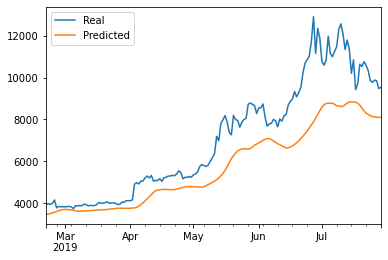

In [117]:
# Plot the real vs predicted values as a line chart
stocks.plot() 